## Problem statement:

ToMe expects a single tensor to be passed to calls to `.attn`

Then inside the attn block, q,k,v are created

Therefore it can merge tokens before entering the attn block and unmerge them coming out and (input, output) will have the same shape.

My problem is that I  am passing in q,k,v to the transformer block, because they tracking some history of q,k,v states

How can I:
- merge(q), merge(k), merge(v)
- out = attn(q, k, v)
- unmerge out without loss of information
??





In [128]:
import torch
import torch.nn.functional as F

from tome import bipartite_soft_matching, apply_merge

%load_ext autoreload
%autoreload 2

In [131]:
# number of tokens to merge
r = 1
# set dty;e
dtype = torch.float32

In [132]:
# manually seeded values all have same value
torch.manual_seed(0)
q = torch.rand(1, 4, 5).to(dtype)
k = q
# change seed for k to get some different value
torch.manual_seed(1)
v = torch.rand(1, 4, 5).to(dtype)
q, v

(tensor([[[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.5185, 0.6977, 0.8000, 0.1610, 0.2823]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
          [0.6387, 0.5247, 0.6826, 0.3051, 0.4635],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

## Combining q,k,v first

In [55]:
qkv = q + k + v
qkv

tensor([[[1.4888, 2.3047, 0.2654, 0.3961, 0.9223],
         [1.9022, 1.4703, 2.6893, 1.3669, 1.8969],
         [1.0467, 1.2052, 0.0670, 0.5066, 0.8817],
         [1.5556, 2.0930, 2.4000, 0.4831, 0.8468]]])

In [45]:
mqkv, uqkv = bipartite_soft_matching(qkv, r)

In [63]:
merged_qkv = apply_merge(qkv, mqkv)
merged_qkv

tensor([[[1.0467, 1.2052, 0.0670, 0.5066, 0.8817],
         [1.9022, 1.4703, 2.6893, 1.3669, 1.8969],
         [1.5222, 2.1988, 1.3327, 0.4396, 0.8845]]])

In [67]:
# chunk back into q, k, v
chunk_q, chunk_k, chunk_v = torch.chunk(merged_qkv, 3, dim=1)
chunk_q

tensor([[[1.0467, 1.2052, 0.0670, 0.5066, 0.8817]]])

In [71]:
# produces attention of incorrect shape
merged_chunk_attn = F.scaled_dot_product_attention(chunk_q, chunk_k, chunk_v)
merged_chunk_attn

tensor([[[1.5222, 2.1988, 1.3327, 0.4396, 0.8845]]])

In [99]:
# get merge, unmerge functions for each token
mq, uq = bipartite_soft_matching(q, r)
mk, uk = bipartite_soft_matching(k, r)
mv, uv = bipartite_soft_matching(v, r)

In [100]:
# merge will also result in the same value
merged_q = apply_merge(q, mq)
merged_k = apply_merge(k, mk)
merged_v = apply_merge(v, mv)
merged_q, merged_v

(tensor([[[0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.5074, 0.7329, 0.4442, 0.1465, 0.2948]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

In [101]:
# unmerging
unmerged_q = uq(merged_q)
unmerged_v = uv(merged_v)
unmerged_q, unmerged_v

(tensor([[[0.5074, 0.7329, 0.4442, 0.1465, 0.2948],
          [0.6341, 0.4901, 0.8964, 0.4556, 0.6323],
          [0.3489, 0.4017, 0.0223, 0.1689, 0.2939],
          [0.5074, 0.7329, 0.4442, 0.1465, 0.2948]]]),
 tensor([[[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.7193, 0.4609, 0.7185, 0.4373, 0.4512],
          [0.4550, 0.5725, 0.4980, 0.9371, 0.6556]]]))

In [102]:
# scaled dot product attention
attn = F.scaled_dot_product_attention(q, k, v)
attn

tensor([[[0.6644, 0.4402, 0.5820, 0.6493, 0.3951],
         [0.6665, 0.4440, 0.5968, 0.6577, 0.4172],
         [0.6651, 0.4410, 0.5845, 0.6426, 0.3957],
         [0.6619, 0.4446, 0.5891, 0.6611, 0.4132]]])

In [103]:
merged_attn = F.scaled_dot_product_attention(merged_q, merged_k, merged_v)
merged_attn

tensor([[[0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
         [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
         [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]])

In [107]:
# Observation: we get different unmerged values using uq and uv which had different matching schemes
# mismatches are only in the first dimension
unmerged_attn = uq(merged_attn)
unmerged_attn_2 = uv(merged_attn)
unmerged_attn, unmerged_attn_2

(tensor([[[0.6389, 0.4495, 0.5561, 0.6908, 0.4058],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
          [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]]),
 tensor([[[0.6420, 0.4424, 0.5467, 0.6977, 0.3897],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6442, 0.4528, 0.5723, 0.6683, 0.4149],
          [0.6389, 0.4495, 0.5561, 0.6908, 0.4058]]]))

## Apply ToMe to Cifar10

In [217]:
## patch embed + pos enc
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from mae import PatchEmbed, Mlp
from util.pos_embed import get_2d_sincos_pos_embed

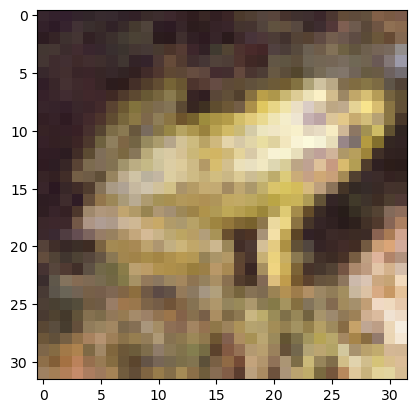

In [252]:
img = read_image('assets/frog.jpg')
plt.imshow(img.permute(1,2,0).numpy())


In [362]:
img = img.to(dtype)
img = F.normalize(img)

In [338]:
embed_dim = 128
patch_size = 4
in_chans = 3
img_size = 32
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
num_patches = patch_embed.num_patches
num_patches

64

In [339]:
pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)
pos_embed.shape

torch.Size([1, 65, 128])

In [340]:
grid_size = int(patch_embed.num_patches**.5)
print(grid_size)
print(pos_embed.shape[-1])
pos_embed_data = get_2d_sincos_pos_embed(pos_embed.shape[-1], grid_size, cls_token=True)
pos_embed_data.shape, pos_embed_data

8
128


((65, 128),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147102,  0.68156135,  0.53316844, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [-0.95892429, -0.57112712,  0.32393527, ...,  0.99999863,
          0.99999923,  0.99999958],
        [-0.27941549, -0.97739613, -0.23036753, ...,  0.99999863,
          0.99999923,  0.99999958],
        [ 0.65698659, -0.85931349, -0.71372128, ...,  0.99999863,
          0.99999923,  0.99999958]]))

In [341]:
# copy data in parameter
pos_embed.data.copy_(torch.from_numpy(pos_embed_data).float().unsqueeze(0))

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.8415,  0.6816,  0.5332,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.9589, -0.5711,  0.3239,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2794, -0.9774, -0.2304,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6570, -0.8593, -0.7137,  ...,  1.0000,  1.0000,  1.0000]]])

In [363]:
# unsqueeze
batched_img = img.unsqueeze(0).to(dtype)
print(batched_img.shape)
x = patch_embed(batched_img)
x.shape

torch.Size([1, 3, 32, 32])


torch.Size([1, 64, 128])

In [343]:
x += pos_embed[:, 1:, :]
x.shape, x

(torch.Size([1, 64, 128]),
 tensor([[[  -7.8969,  -29.3244,  -63.0857,  ...,    0.3936,    5.3780,
             39.3657],
          [  -2.9058,  -24.1002,  -57.5107,  ...,   -0.5091,    4.5655,
             43.3625],
          [   4.4390,  -35.3252,  -60.4515,  ...,    6.2933,    3.8840,
             49.8933],
          ...,
          [  -5.6575,  -70.3900, -166.7340,  ...,   12.8151,  -22.8375,
             88.1303],
          [   4.5165,  -44.6639, -182.0947,  ...,    4.3388,   -3.7992,
            108.5713],
          [ -13.6902,  -99.2074, -233.6833,  ...,   -2.2315,   -6.4996,
            117.8709]]], grad_fn=<AsStridedBackward0>))

## Separating Out Attention

Get Q,K,V separately

Then apply scaled dot product attention

In [344]:
# fully connected layers to get q, k, v from embed
to_q = torch.nn.Linear(embed_dim, embed_dim)
to_k = torch.nn.Linear(embed_dim, embed_dim)
to_v = torch.nn.Linear(embed_dim, embed_dim)

# sourced from fully connected layer
fcq, fck, fcv = to_q(x), to_k(x), to_v(x)
fcq.shape, fcq

(torch.Size([1, 64, 128]),
 tensor([[[ 31.7062, -10.1665, -16.0091,  ..., -20.7007, -20.4802,  -6.5850],
          [ 30.6331,  -6.2660, -19.0779,  ..., -20.7150, -21.7310,  -6.3247],
          [ 28.4920,  -3.4446, -19.5949,  ..., -25.7851, -21.3614,   0.7119],
          ...,
          [ 76.2984, -13.3087, -55.9397,  ..., -52.7782, -50.9471, -20.7806],
          [ 93.0243, -21.2017, -67.1351,  ..., -60.7705, -59.6432, -35.4072],
          [135.9153, -13.0263, -69.5897,  ..., -96.1189, -76.2452, -30.1858]]],
        grad_fn=<AddBackward0>))

In [345]:
# Examine attention output with no merging
original_fcattn = F.scaled_dot_product_attention(fcq, fck, fcv)
original_fcattn.shape

torch.Size([1, 64, 128])

In [346]:
# pass through Mlp
mlp_ratio = 4
mlp = Mlp(in_features=embed_dim, hidden_features=int(embed_dim*mlp_ratio),act_layer=torch.nn.GELU)
x = mlp(x)
x.shape

torch.Size([1, 64, 128])

In [170]:
# now we want to merge all of them
cifar_r = 10 # might higher merge rate r because we have a larger embed dim
mfcq, ufcq = bipartite_soft_matching(fcq, cifar_r)
merged_fcq = apply_merge(fcq, mfcq)
merged_fcq

tensor([[[-3.8079e+01, -4.4589e+01,  1.2494e+01, -3.5141e+01, -3.4229e+01,
          -1.0312e+01,  3.9906e+00,  2.6112e+01, -2.6709e+01,  2.3092e+01,
          -2.1703e+01,  3.9743e+01],
         [-7.0699e+01, -8.5814e+01,  1.6703e+01, -6.4156e+01, -5.8966e+01,
          -1.7860e+01,  2.2226e+01,  5.0801e+01, -4.0335e+01,  3.1270e+01,
          -3.9781e+01,  6.5680e+01],
         [-7.8078e+01, -8.6140e+01,  1.6419e+01, -4.4817e+01, -6.6045e+01,
          -1.1408e+01,  2.3805e+01,  5.9632e+01, -3.4035e+01,  2.8686e+01,
          -3.8101e+01,  5.1275e+01],
         [-4.7216e+01, -4.8944e+01,  1.3678e+01, -3.1118e+01, -4.1402e+01,
          -5.6516e+00,  1.5331e+01,  4.0762e+01, -2.6380e+01,  2.0535e+01,
          -1.8657e+01,  4.1567e+01],
         [-5.5042e+01, -5.6675e+01,  1.7649e+01, -5.0718e+01, -4.7245e+01,
          -1.1114e+01,  7.4638e+00,  3.7138e+01, -3.2238e+01,  2.9612e+01,
          -2.8822e+01,  5.2188e+01],
         [-3.8005e+01, -3.8974e+01,  1.2002e+01, -2.2286e+01, -3.

In [172]:
# use same merging function for all 3?
merged_fck = apply_merge(fck, mfcq)
merged_fcv = apply_merge(fcv, mfcq)
merged_fck.shape

torch.Size([1, 54, 12])

In [176]:
# attention between all 3 now
# appears that each value is off by about 10, which is the reduction ratio
merged_fcattn = F.scaled_dot_product_attention(merged_fcq, merged_fck, merged_fcv)
merged_fcattn

tensor([[[-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43

In [179]:
# unmerge the attention
fc_attn = ufcq(merged_fcattn)
fc_attn

tensor([[[-49.4299, -23.7361,  -1.1053,  31.8815,  -7.9346,  66.6388, -86.4365,
          -17.1419,  37.2805, -36.1231, -19.8001,  -3.0767],
         [-49.4299, -23.7361,  -1.1053,  31.8815,  -7.9346,  66.6388, -86.4365,
          -17.1419,  37.2805, -36.1231, -19.8001,  -3.0767],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43.4441,   2.2759,  -4.3172,   8.7908, -14.0302,  44.2026, -69.1611,
            3.5828,  41.8453, -13.7127, -24.3745,   1.3579],
         [-43

## Restore original image

Data flows through variable called `x`

In [347]:
# unpatch embed vector
def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = patch_embed.patch_size[0]
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [263]:
# set x to whichever attn output we want
x = x

In [348]:
# normalize
norm = torch.nn.LayerNorm(embed_dim)
x = norm(x)

# change back to 3 channels
pred_fc = torch.nn.Linear(embed_dim, patch_size **2 * in_chans, bias=True)
x = pred_fc(x)
x

tensor([[[ 0.5157,  0.9371,  0.5276,  ..., -0.4513,  0.6232,  0.1919],
         [ 0.5393,  0.8178,  0.6809,  ..., -0.5261,  0.5184,  0.1275],
         [ 0.5337,  0.7038,  0.5630,  ..., -0.6070,  0.5394,  0.4655],
         ...,
         [ 0.2646,  0.5606,  0.5818,  ..., -0.6069,  0.3468, -0.0211],
         [ 0.7251,  0.6559,  0.5164,  ..., -0.7048,  0.6041, -0.0169],
         [ 0.6021,  0.7157,  0.5304,  ..., -0.5704,  0.5544,  0.2615]]],
       grad_fn=<ViewBackward0>)

In [349]:
x = unpatchify(x)
x.shape

torch.Size([1, 3, 32, 32])

In [273]:
def vis(x):
    tmp_img = x.squeeze(0).permute(1, 2, 0).detach().numpy()
    tmp_img = tmp_img - tmp_img.min()  # Shift to 0..range
    tmp_img = tmp_img / tmp_img.max()  # Scale to 0..1
    tmp_img = tmp_img * 255.0  # Scale to 0..255

    # Step 3: Convert to uint8
    tmp_img = tmp_img.astype(np.uint8)
    plt.imshow(tmp_img)

## Loss function: MSE or pixel reconstruction

In [428]:
# calculate backward pass of MSE
def mse(pred, truth):
    loss = (pred - truth) ** 2
    loss = loss.mean(dim=-1)
    loss = loss.sum()
    return loss

In [462]:
# combine all elements into a single module
class EncoderBlock(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.to_q = torch.nn.Linear(dim, dim)
        self.to_k = torch.nn.Linear(dim, dim)
        self.to_v = torch.nn.Linear(dim, dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim*mlp_ratio, act_layer=torch.nn.GELU)
    
    def forward(self, x):
        x = self.norm1(x)
        fcq, fck, fcv = self.to_q(x), self.to_k(x), self.to_v(x)
        x = F.scaled_dot_product_attention(fcq, fck, fcv)
        x = self.norm2(x)
        x = self.mlp(x)
        return x

In [463]:
# instantiate encoder
enc1 = EncoderBlock(embed_dim)
enc2 = EncoderBlock(embed_dim)
# add params to optimizer
# optimizer.param_groups.append({'params': enc.parameters()})

## Observation

If embed_dim = 128, then adding a second encoder block makes it reproduce jibberish

If embed_dim = 12, then adding a second encoder block is necessary to produce a meaningful output

In [464]:
# make optimizer from existing params
from itertools import chain

lr = 0.001
weight_decay = 0.05

params = chain(
    patch_embed.parameters(),
    pos_embed,
    enc1.parameters(),
    # enc2.parameters(),
    norm.parameters(),
    pred_fc.parameters()
)

optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)


In [465]:
# another pass
def forward(img):
    # patch and pos embed
    x = patch_embed(img)
    x += pos_embed[:, 1:, :]
    
    # encoder
    x = enc1(x)
    # x = enc2(x)

    # decoder
    x = norm(x)
    x = pred_fc(x)
    x = unpatchify(x)
    return x

In [466]:
loss_fn = torch.nn.L1Loss(reduction='sum')
# loss_fn = mse

In [467]:
# effectively training for 10k iterations
num_iterations = 2000
for i in range(num_iterations):
    optimizer.zero_grad()

    pred = forward(batched_img)
    
    loss = loss_fn(pred, batched_img)
    
    if i % 100 == 0:
        print(loss.item())

    # print(mlp.fc1.weight)

    loss.backward()

    optimizer.step()


370.7978820800781
91.11599731445312
83.63531494140625
78.3860092163086
68.90133666992188
58.674129486083984
52.14320755004883
47.2696647644043
36.640220642089844
26.48609733581543
23.0140323638916
18.49424934387207
17.55229949951172
11.86535930633545
14.346924781799316
8.708592414855957
10.531471252441406
7.670478343963623
7.711460590362549
8.42731761932373


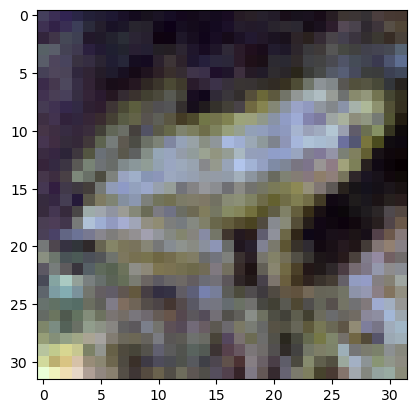

In [468]:
vis(pred) # no change in reconstruction :(

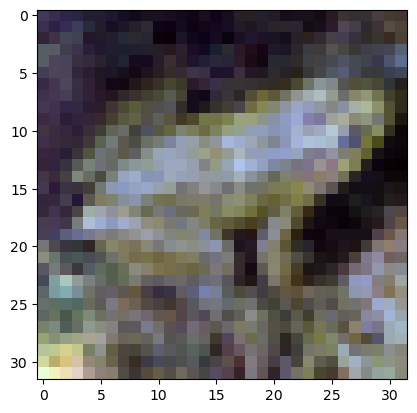

In [469]:
vis(img)

## Repeat but with token merging

In [526]:
# combine all elements into a single module
class ToMeBlock(torch.nn.Module):
    def __init__(self, dim, reduce_by=0.25):
        super().__init__()
        self.norm1 = torch.nn.LayerNorm(dim)
        self.norm2 = torch.nn.LayerNorm(dim)
        self.to_q = torch.nn.Linear(dim, dim)
        self.to_k = torch.nn.Linear(dim, dim)
        self.to_v = torch.nn.Linear(dim, dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim*mlp_ratio, act_layer=torch.nn.GELU)
        self.reduce_by = reduce_by
    
    def forward(self, x):
        x = self.norm1(x)
        fcq, fck, fcv = self.to_q(x), self.to_k(x), self.to_v(x)
        # get merge and unmerge functions
        r = int(fcq.shape[1] * self.reduce_by)
        mq, uq = bipartite_soft_matching(fcq, r)
        # apply merge to q,k,v
        mfcq, mfck, mfcv = apply_merge(fcq, mq), apply_merge(fck, mq), apply_merge(fcv, mq)
        x = F.scaled_dot_product_attention(mfcq, mfck, mfcv)
        # unmerge output
        x = uq(x)
        x = self.norm2(x)
        x = self.mlp(x)
        return x
    
class ToMeNet(torch.nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=128, reduce_by=0.25):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)
        self.num_patches = self.patch_embed.num_patches
        self.grid_size = int(self.num_patches**.5)
        # init weight for pos embed
        pos_embed_data = get_2d_sincos_pos_embed(pos_embed.shape[-1], grid_size, cls_token=True)
        pos_embed.data.copy_(torch.from_numpy(pos_embed_data).float().unsqueeze(0))

        self.enc1 = ToMeBlock(embed_dim, reduce_by=reduce_by)
        # self.enc2 = ToMeBlock(embed_dim, reduce_by=reduce_by)

        self.norm = torch.nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, patch_size **2 * in_chans, bias=True)

    def forward(self, x):
        x = self.patch_embed(x)
        x += self.pos_embed[:, 1:, :]
        
        # encoder
        x = self.enc1(x)
        # x = self.enc2(x)

        # decoder
        x = self.norm(x)
        x = self.fc(x)
        x = unpatchify(x)
        return x

In [534]:
net = ToMeNet()
tome_optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [535]:
def train(model, num_iterations, loss_fn, optimizer):
    for i in range(num_iterations):
        optimizer.zero_grad()

        pred = model(batched_img)
        
        loss = loss_fn(pred, batched_img)
        
        if i % 100 == 0:
            print(loss.item())

        loss.backward()

        optimizer.step()

In [536]:
num_iterations = 2000
train(net, num_iterations, loss_fn, tome_optimizer)

1462.315185546875
93.50597381591797
85.75689697265625
77.16730499267578
71.64138793945312
71.12393951416016
73.12084197998047
67.27326965332031
68.82512664794922
66.95525360107422
67.7804183959961
59.43033218383789
57.50318908691406
50.854095458984375
46.88896179199219
44.69001770019531
48.95608139038086
42.14002227783203
39.061275482177734
40.89096450805664


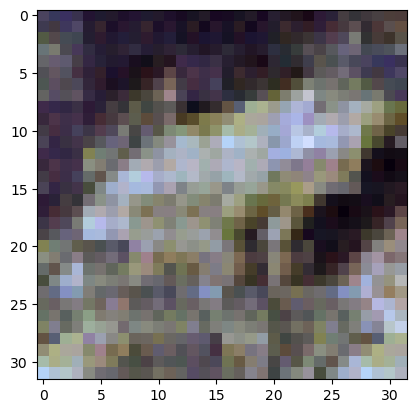

In [531]:
vis(pred)

In [537]:
reduce_by = 0.5 # reduction ration for ToMe, merge up to 50% of tokens
net2 = ToMeNet(reduce_by=reduce_by)
tome_optimizer2 = torch.optim.Adam(net2.parameters(), lr=lr, weight_decay=weight_decay)

In [538]:
train(net2, num_iterations, loss_fn, tome_optimizer2)

1518.1292724609375
101.20988464355469
90.72547912597656
78.86808776855469
74.18560028076172
73.1738510131836
72.43730926513672
72.04017639160156
72.96987915039062
67.8051528930664
68.68719482421875
64.26290893554688
64.07304382324219
62.334617614746094
60.649593353271484
61.814292907714844
63.60616683959961
58.03437042236328
59.623653411865234
59.513240814208984


In [ ]:
vis(pred)

## Observations
There is no loss of information in the representation with token merging

Until getting closer to 50%